In [117]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
from matplotlib.collections import LineCollection
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

%load_ext autoreload
%autoreload 2

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Transport import *

import plotutil, randutil

def plot_density(ax, t, n=200, alpha=1, qcs=None, cmap='viridis') :
    x = np.linspace(-1,1,n)
    X, Y = np.meshgrid(x, x)
    pts = np.vstack((X.flatten(), Y.flatten()))
    Ztar = np.ones((len(x), len(x)))
    if t is not None :
        Ztar = t.eval(pts).reshape((len(x), len(x)))
    if qcs is not None :
        return ax.contourf(X, Y, Ztar, levels=qcs.levels, extend='both', cmap=cmap, alpha=alpha)
    return ax.contourf(X, Y, Ztar, cmap=cmap, alpha=alpha)

def get_ax_clean(fig, nx=1, ny=1, n=1, title='') :
    ax = fig.add_subplot(ny,nx,n)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    return ax

def plot_results(t, s, p_uni, p_tar, lines, lines_t) :
    n = 4
    fig = plt.figure(figsize=(n*8,8))
    ax = get_ax_clean(fig, nx=n, n=1); qcs = plot_density(ax, t, cmap='Blues')
    ax = get_ax_clean(fig, nx=n, n=2); plot_density(ax, s, qcs=qcs, cmap='Blues')
    ax = get_ax_clean(fig, nx=n, n=3); ax.scatter(p_tar[0], p_tar[1], s=50, alpha=.6)
    for l in lines_t : 
        ax.plot(l[0], l[1], '#c8c8c8', lw=2)
    ax = get_ax_clean(fig, nx=n, n=4); ax.scatter(p_uni[0], p_uni[1], s=50, alpha=.6)
    for l in lines : 
        ax.plot(l[0], l[1], '#c8c8c8', lw=2)
    plt.tight_layout()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1D

In [63]:
arglist = [{'mean' : randutil.points(1,1), 'cova' : randutil.covarm(1)},
           {'mean' : randutil.points(1,1), 'cova' : randutil.covarm(1)}]
print(arglist)
t_1d = GaussianMixture(dim=1, arglist=arglist, save=False)
m_1d = TotalDegreeSet(dim=1, order=15)
s_1d = Legendre(multis=m_1d, target=t_1d, method='wls')
r_1d = TransportMap(s_1d)

[{'mean': array([[-0.56216555]]), 'cova': array([[0.0369403]])}, {'mean': array([[0.58094559]]), 'cova': array([[0.07983934]])}]
 ///////////  16 (320, 16) 75.8783757565876
condition number  4.301302608765317


In [64]:
p_uni_1d, p_tar_1d = r_1d.samples(500)

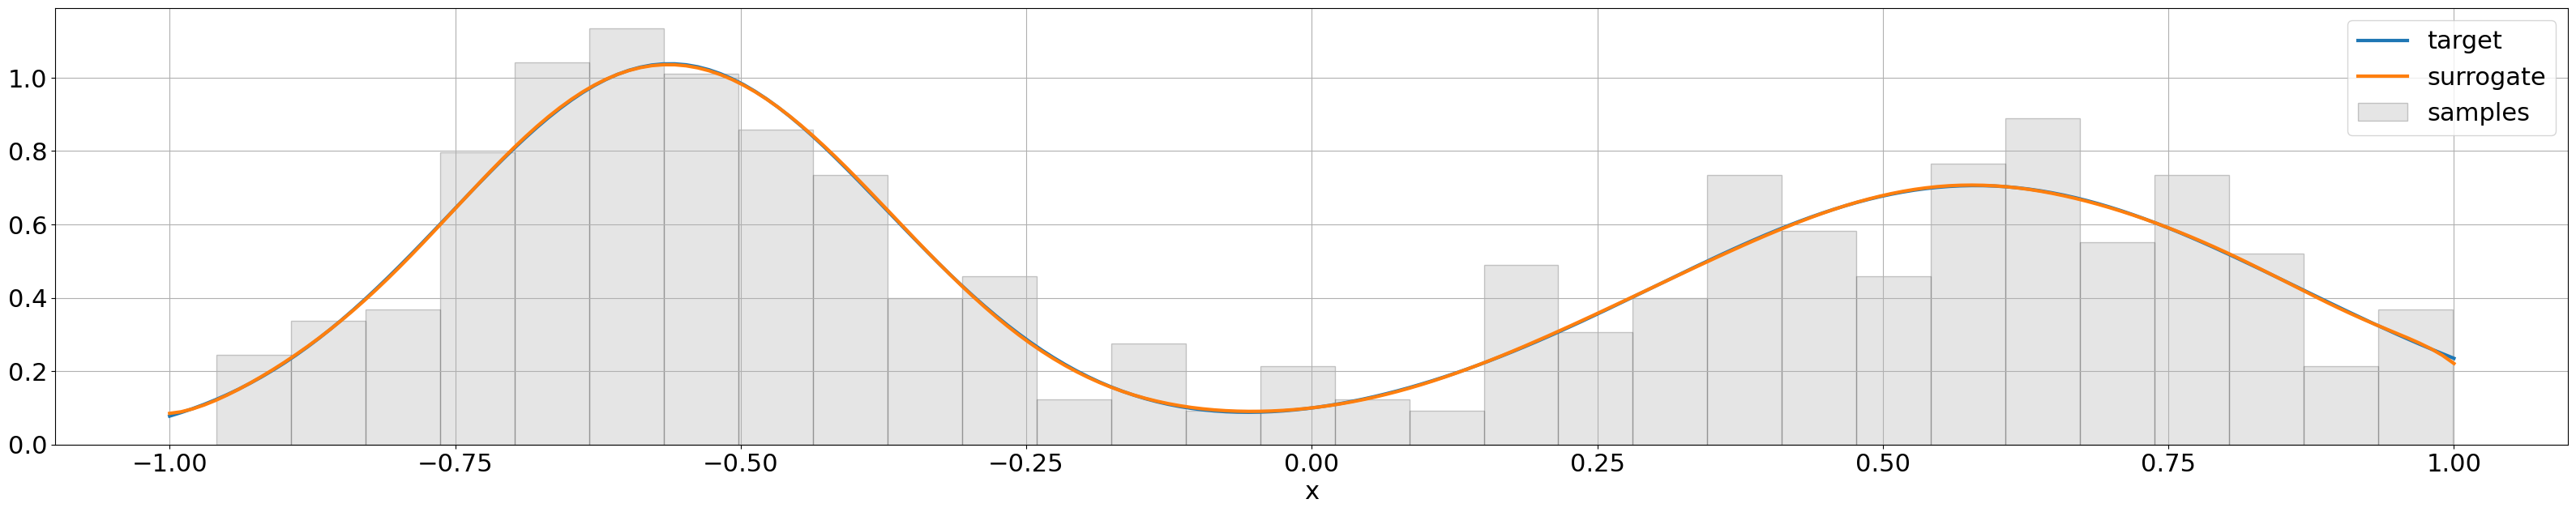

In [65]:
x = np.linspace(-1,1,200)
ax = plotutil.get_ax(plt.figure(), 1, 1)
ax.plot(x, t_1d.eval(x), lw=3, label='target')
ax.plot(x, s_1d.eval(x), lw=3, label='surrogate')
ax.hist(p_tar_1d[0], bins=30, color='grey', ec='k', alpha=.2, label='samples', density=True)
ax.legend()
plt.show()

# Multimodal Densities

In [87]:
class MultimodalDensity(TargetDensity) :
    def __init__(self, *, densities, weights) :
        assert(len(densities) == len(weights))
        TargetDensity.__init__(self, 2, 'MultimodalDensity')
        self.densities = densities
        self.weights = weights
        
    def eval(self, x) :
        return np.sum([w*d.eval(x) for w, d in zip(self.weights,self.densities)], axis=0)\

class Hat(TargetDensity) :
    def __init__(self, *, c=[-.5,.3], m=1, x=[-.7,-.3], y=[.2,.6], theta=0, scale=1) :
        assert(x[0] <= c[0] and c[0] <= x[1] and y[0] <= c[1] and c[1] <= y[1])
        TargetDensity.__init__(self, 2, 'Hats')
        self.arcsins1 = np.array([m/(c[0]-x[0]), m/(c[1]-y[0]), m/(x[1]-c[0]), m/(y[1]-c[1])])
        self.c = np.array(c)
        self.x = x
        self.y = y
        self.rotation = np.array([[np.cos(theta), - np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        self.scale = scale

    def eval(self, x) :
        x = self.scale * np.dot(self.rotation, x)
        res = np.zeros((x.shape[1]))
        ind = (x[0,:] >= self.x[0]) & (x[0,:] <= self.x[1]) & (x[1,:] >= self.y[0]) & (x[1,:] <= self.y[1])
        if ind.any() :
            res[ind] = np.vstack((self.arcsins1[0]*np.abs(self.x[0]-x[0,ind]), self.arcsins1[1]*np.abs(self.y[0]-x[1,ind]), self.arcsins1[2]*np.abs(self.x[1]-x[0,ind]), self.arcsins1[3]*np.abs(self.y[1]-x[1,ind]))).min(axis=0)
        return res
    
t_m = MultimodalDensity(densities=[Gaussian(mean=np.array([-.45,.5]), cova=np.array([[ 0.02, .018], [0,  0.01]])), 
                                   Rosenbrock(a=.2, b=8, theta=-2.2/10*np.pi, centr=np.array([.5,-.5]), scale=1.1)],
                        weights=[.09,1])
m_m = TotalDegreeSet(dim=2, order=29)
s_m = Legendre(multis=m_m, target=t_m, method='wls')
r_m = TransportMap(s_m)

 ///////////  465 (27900, 465) 1904.5639900505482
condition number  11.242246560611811


In [90]:
p_uni_m, p_tar_m = r_m.samples(500)

In [97]:
lines_m, lines_t_m = r_m.grid(xs=[-1, -.8, -.4, -.2, 1], ns=[100, 100, 20, 50])

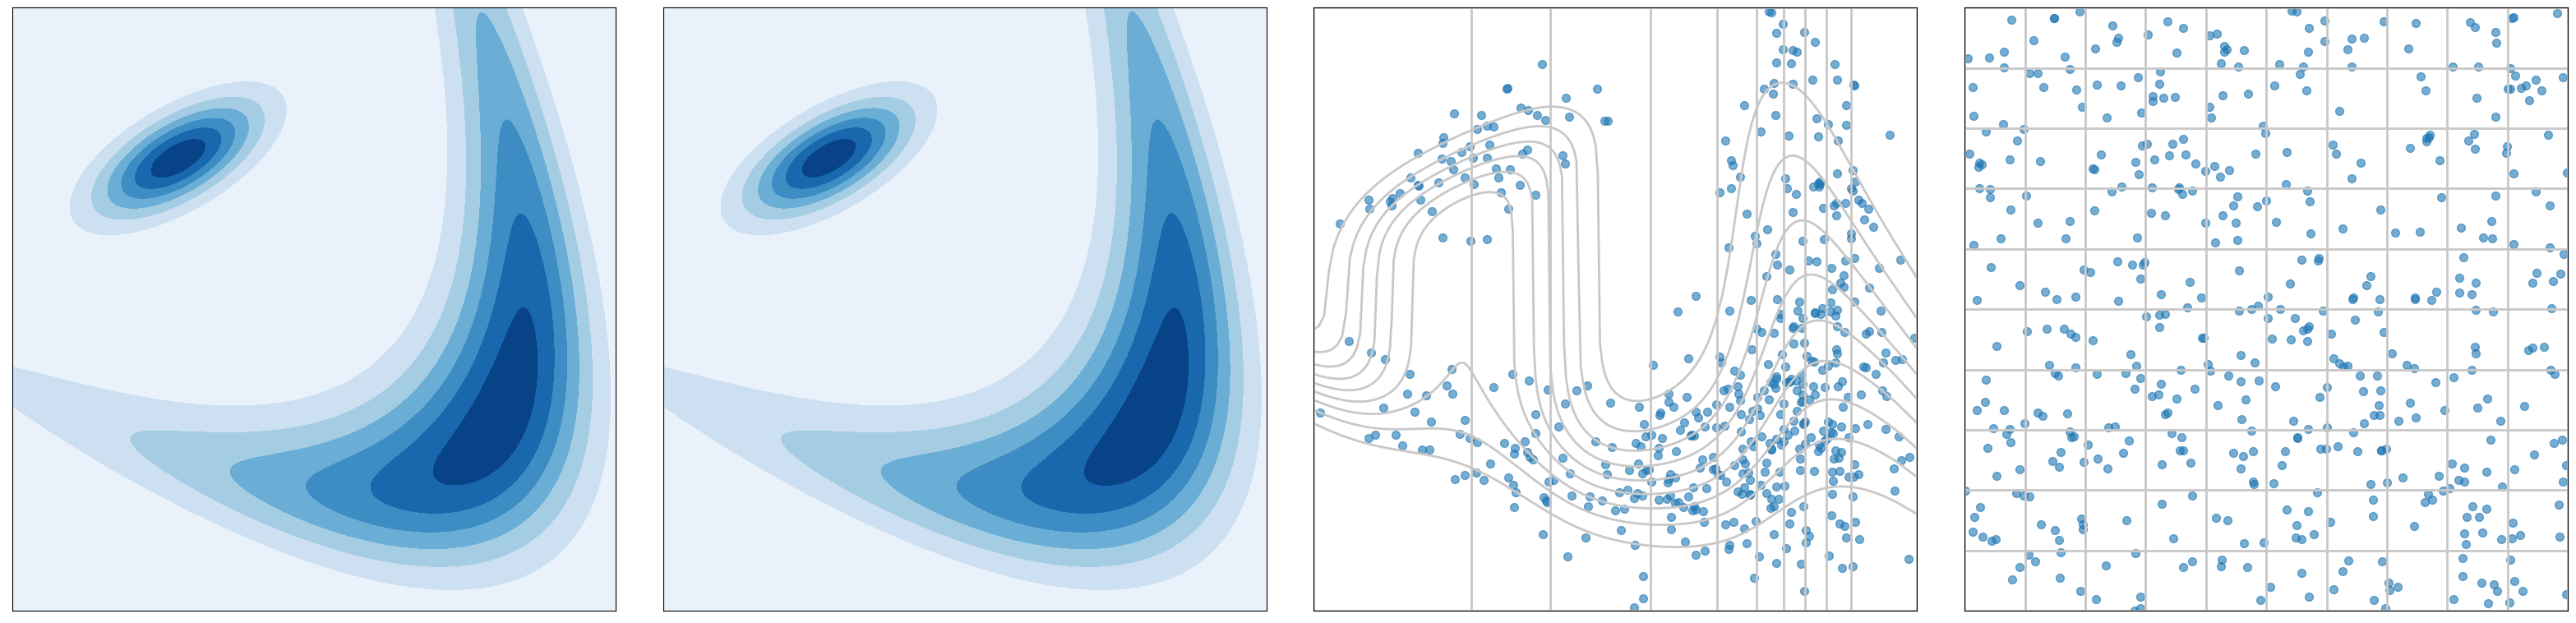

In [112]:
plot_results(t_m, s_m, p_uni_m, p_tar_m, lines_m, lines_t_m)

In [126]:
m_mlr = TotalDegreeSet(dim=2, order=7)
s_mlr = Legendre(multis=m_mlr, target=t_m, method='wls')

 ///////////  36 (1080, 36) 81.75659492181552
condition number  3.312809543733387


In [114]:
r_mlr = TransportMap(s_mlr)
p_uni_m, p_tar_mlr = r_mlr.samples(500, p_uni_m)

In [119]:
lines_mlr, lines_t_mlr = r_mlr.grid(xs=[-1, -.8, -.4, -.2, .9, 1], ns=[100, 100, 20, 50, 50])

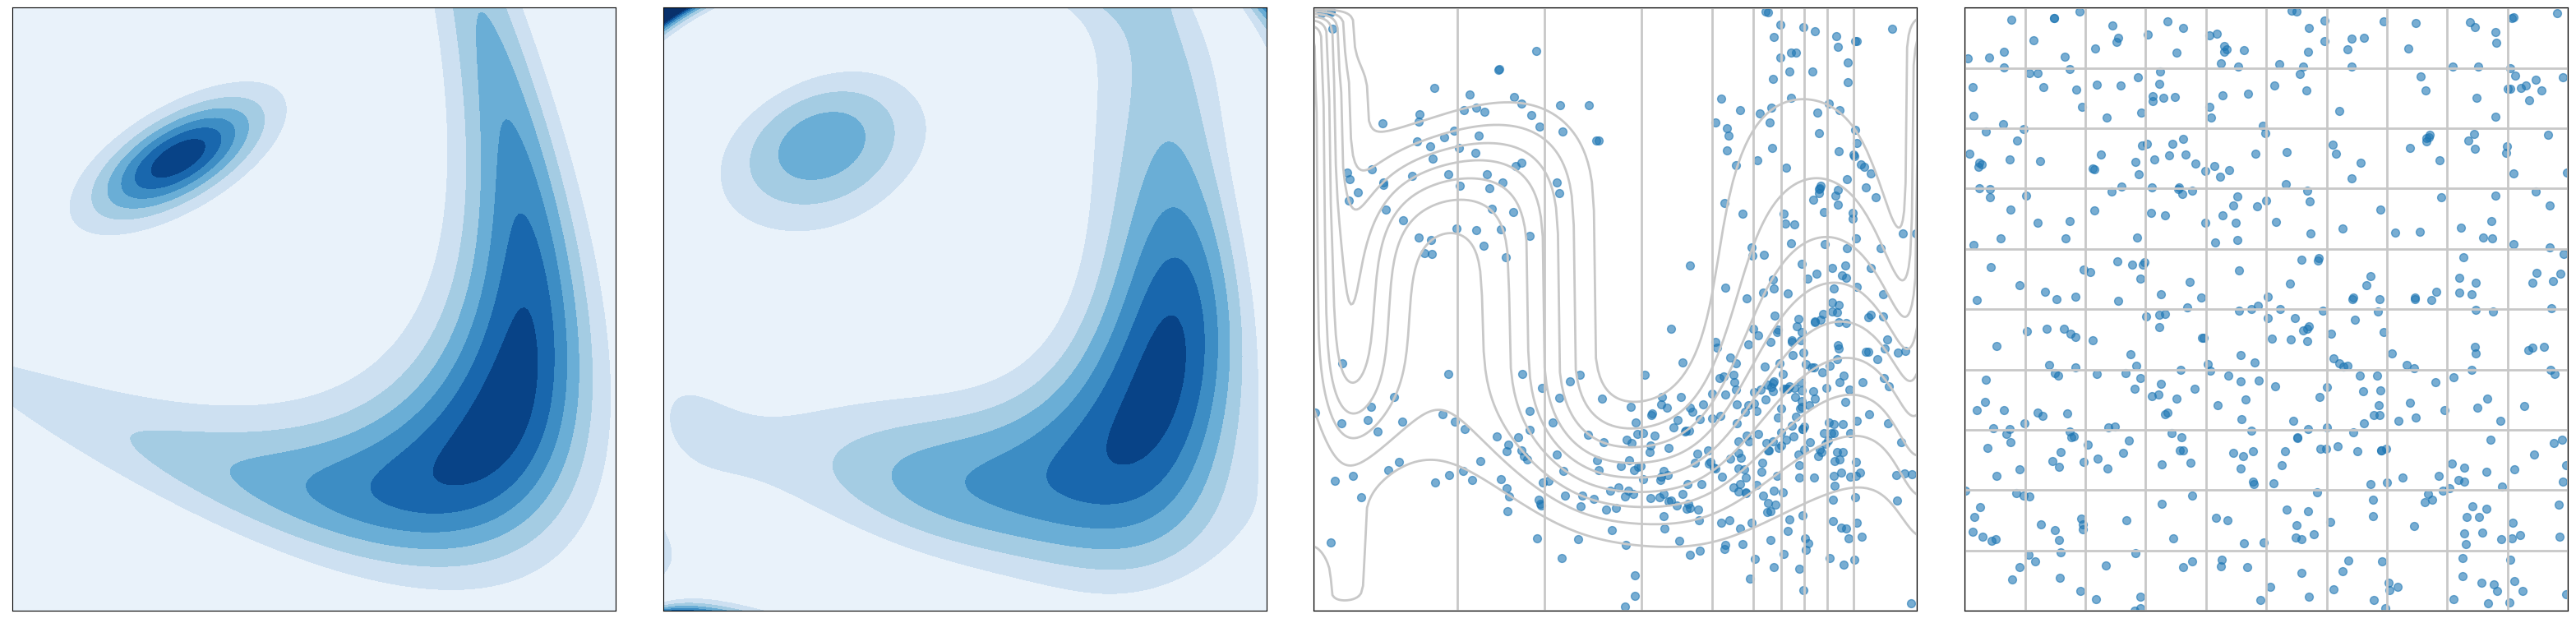

In [120]:
plot_results(t_m, s_mlr, p_uni_m, p_tar_mlr, lines_mlr, lines_t_mlr)

In [188]:
tex = 1
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", "text.usetex": True, "pgf.rcfonts": False})

ax = get_ax_clean(plt.figure(figsize=(10,10)), nx=1, n=1); 

#fname = 'target_density'
#qcs = plot_density(ax, t_m, cmap='Blues')
#ax.text(-.92,.92, '(b)', fontsize=45, bbox={'boxstyle' : 'round', 'color' : 'white', 'ls' : '-', 'lw' : 1, 'ec' : 'k'}, horizontalalignment='left', verticalalignment='top')

#fname = 'uniform_samples'
#ax.scatter(p_uni_m[0], p_uni_m[1], s=50, alpha=.6)
#for l in lines_m : ax.plot(l[0], l[1], '#c8c8c8', lw=2)
#ax.text(-.92,.92, '(a)', fontsize=45, bbox={'boxstyle' : 'round', 'color' : 'white', 'ls' : '-', 'lw' : 1, 'ec' : 'k'}, horizontalalignment='left', verticalalignment='top')

#fname = 'target_samples'
#ax.scatter(p_tar_m[0], p_tar_m[1], s=50, alpha=.6)
#for l in lines_t_m : ax.plot(l[0], l[1], '#c8c8c8', lw=2)
#ax.text(-.92,.92, '(c)', fontsize=45, bbox={'boxstyle' : 'round', 'color' : 'white', 'ls' : '-', 'lw' : 1, 'ec' : 'k'}, horizontalalignment='left', verticalalignment='top')

#fname = 'surrogate_density'
#plot_density(ax, s_mlr, qcs=qcs, cmap='Blues')
#ax.text(-.92,.92, '(d)', fontsize=45, bbox={'boxstyle' : 'round', 'color' : 'white', 'ls' : '-', 'lw' : 1, 'ec' : 'k'}, horizontalalignment='left', verticalalignment='top')

#fname = 'surrogate_samples'
#ax.scatter(p_tar_mlr[0], p_tar_mlr[1], s=50, alpha=.6)
#for l in lines_t_mlr : ax.plot(l[0], l[1], '#c8c8c8', lw=2)
#ax.text(-.92,.92, '(e)', fontsize=45, bbox={'boxstyle' : 'round', 'color' : 'white', 'ls' : '-', 'lw' : 1, 'ec' : 'k'}, horizontalalignment='left', verticalalignment='top')

plt.tight_layout()
if tex : plt.savefig('/home/uq/notes/02 transport maps poster/figures/' + fname + '.pgf', format='pgf')
else :   plt.show()

# Circle

In [2]:
t_c = Circle(c=np.array([[.4],[-.2]]), r=.4, w=.2)
m_c = TotalDegreeSet(dim=2, order=15)
s_c = Legendre(multis=m_c, target=t_c, method='wls')
r_c = TransportMap(s_c)

 ///////////  136 (5440, 136) 409.1551663654521
condition number  6.394620270622908


In [3]:
p_uni_c, p_tar_c = r_c.samples(500)

In [4]:
lines_c, lines_t_c = r_c.grid(xs=[-1, -.9, -.8, -.4, 0, .4, .8, 1], ns=[200, 50, 20,20, 20, 20, 50])

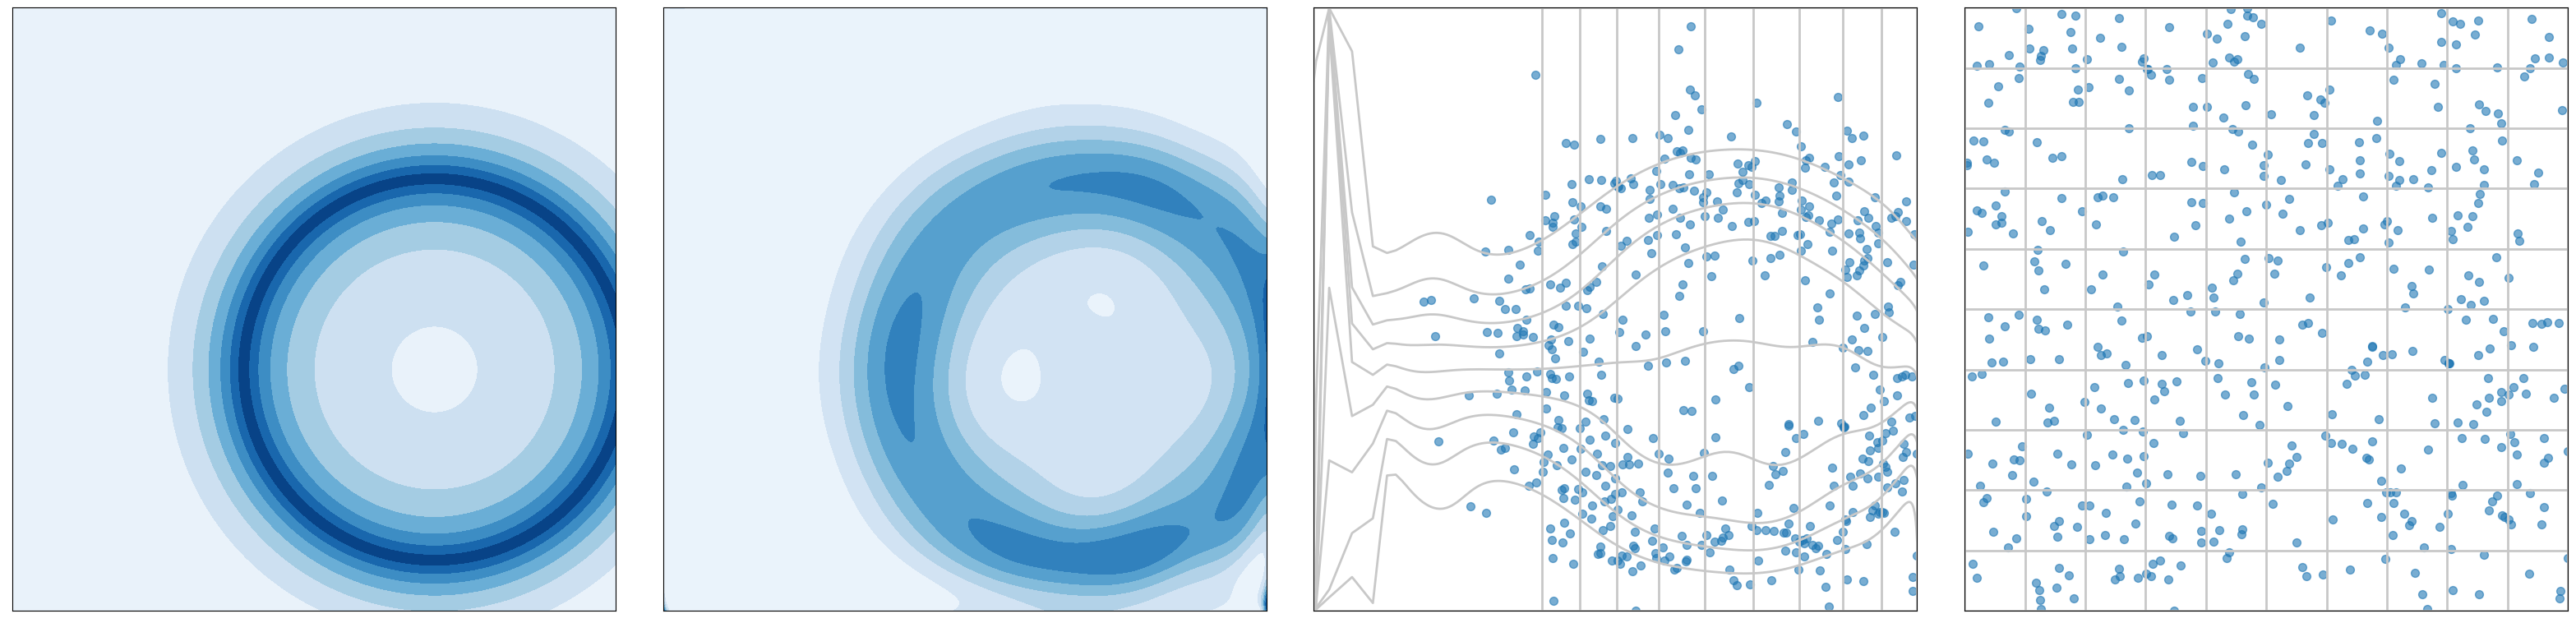

In [5]:
plot_results(t_c, s_c, p_uni_c, p_tar_c, lines_c, lines_t_c)

# Hat functions

In [19]:
class HatsX(TargetDensity) :
    def __init__(self, *, x1=-.7, y1=.8, m1=1, x2=.6, y2=-.4, m2=2, c=.3) :
        assert(x1 < c and c < x2)
        TargetDensity.__init__(self, 2, 'Hats')
        self.arcsins1 = np.array([m1/(x1+1), m1/(y1+1), m1/(c-x1), m1/(1-y1)])
        self.arcsins2 = np.array([m2/(x2-c), m2/(y2+1), m2/(1-x2), m2/(1-y2)])
        self.c  = c

    def eval(self, x) :
        res = np.zeros((x.shape[1]))
        ind = x[0,:] <= self.c
        if ind.any() :
            res[ind] = np.vstack((self.arcsins1[0]*np.abs(1+x[0,ind]), self.arcsins1[1]*np.abs(-1-x[1,ind]), self.arcsins1[2]*np.abs(self.c-x[0,ind]), self.arcsins1[3]*np.abs(1-x[1,ind]))).min(axis=0)
        ind = x[0,:] > self.c
        if ind.any() :
            res[ind] = np.vstack((self.arcsins2[0]*np.abs(self.c-x[0,ind]), self.arcsins2[1]*np.abs(-1-x[1,ind]), self.arcsins2[2]*np.abs(1-x[0,ind]), self.arcsins2[3]*np.abs(1-x[1,ind]))).min(axis=0)
        return res

In [20]:
t_hx = HatsX()
m_hx = TotalDegreeSet(dim=2, order=20)
s_hx = Legendre(multis=m_hx, target=t_hx, method='wls')
r_hx = TransportMap(s_hx)

 ///////////  231 (11550, 231) 1057.3156607733506
condition number  7.786698299233334


In [21]:
p_uni_hx, p_tar_hx = r_hx.samples(300)

In [22]:
lines_hx, lines_t_hx = r_hx.grid()

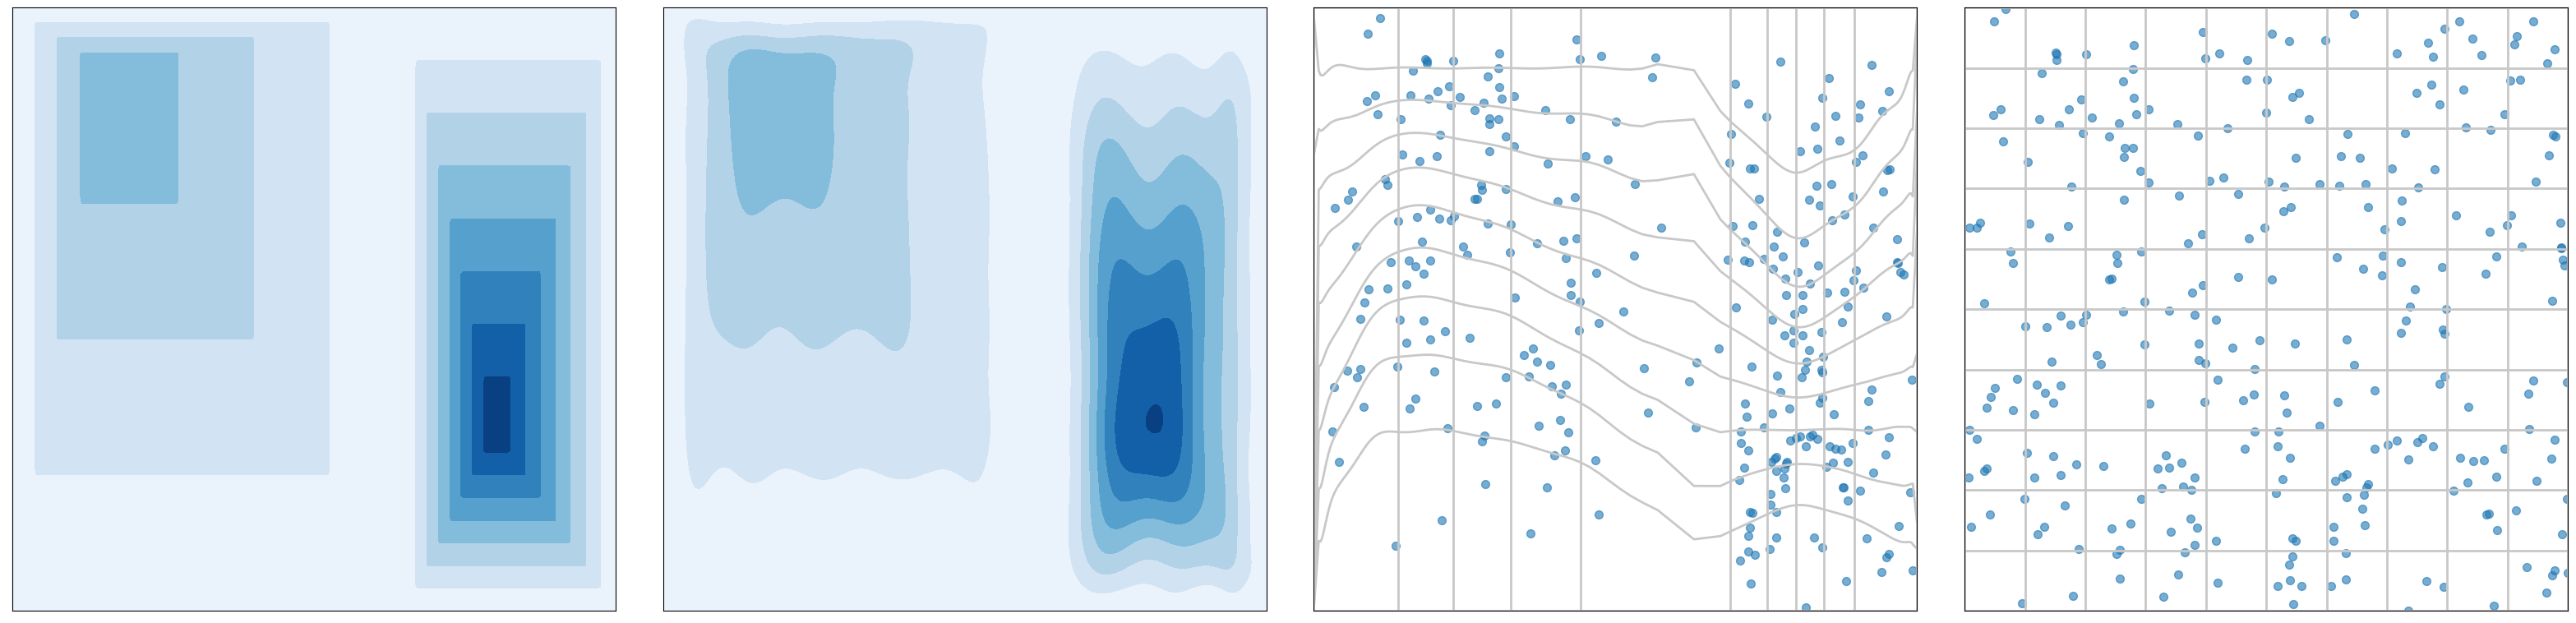

In [23]:
plot_results(t_hx, s_hx, p_uni_hx, p_tar_hx, lines_hx, lines_t_hx)

In [24]:
class HatsY(TargetDensity) :
    def __init__(self, *, x1=.8, y1=-.7, m1=1, x2=-.4, y2=.6, m2=2, c=.3) :
        assert(y1 < c and c < y2)
        TargetDensity.__init__(self, 2, 'Hats')
        self.arcsins1 = np.array([m1/(x1+1), m1/(y1+1), m1/(1-x1), m1/(c-y1)])
        self.arcsins2 = np.array([m2/(x2+1), m2/(y2-c), m2/(1-x2), m2/(1-y2)])
        self.c  = c

    def eval(self, x) :
        res = np.zeros((x.shape[1]))
        ind = x[1,:] <= self.c
        if ind.any() :
            res[ind] = np.vstack((self.arcsins1[0]*(1+x[0,ind]), self.arcsins1[1]*(1+x[1,ind]), self.arcsins1[2]*(1-x[0,ind]), self.arcsins1[3]*(self.c-x[1,ind]))).min(axis=0)
        ind = x[1,:] > self.c
        if ind.any() :
            res[ind] = np.vstack((self.arcsins2[0]*(1+x[0,ind]), self.arcsins2[1]*(x[1,ind]-self.c), self.arcsins2[2]*(1-x[0,ind]), self.arcsins2[3]*(1-x[1,ind]))).min(axis=0)
        return res

In [25]:
t_hy = HatsY()
m_hy = TotalDegreeSet(dim=2, order=25)
s_hy = Legendre(multis=m_hy, target=t_hy, method='wls')
r_hy = TransportMap(s_hy)

 ///////////  351 (17550, 351) 1086.676427997812
condition number  10.374526965912526


In [26]:
p_uni_hy, p_tar_hy = r_hy.samples(300)

In [27]:
lines_hy, lines_t_hy = r_hy.grid(xs=[-1,-.9,-.8,-.2,0,.2,.8,.9, 1], ns=[50,20,10,100,10,10,20,50])

$$\require{color}
T^{-1}_{j}(x_1, ..., x_j) = 
\frac{\int\limits_{\textcolor{red}{[0,1]^{d-j}}} \int\limits_{\textcolor{green}{0}}^{\textcolor{green}{x_j}} f(\textcolor{blue}{x_1, ..., x_{j-1}},\textcolor{green}{t}, \textcolor{red}{x_{j+1}, ..., x_d}) \textcolor{green}{d t}\textcolor{red}{ d x_{j+1}, ..., d x_d}}
{\int\limits_{\textcolor{red}{[0,1]^{d-j+1}}} f (\textcolor{blue}{x_1, ..., x_{j-1}}, \textcolor{red}{x_j, ..., x_d}) \textcolor{red}{ d x_j, ..., d x_d}}$$

In [ ]:
axs = plot_results(t_hy, s_hy, p_uni_hy, p_tar_hy, lines_hy, lines_t_hy)

In [28]:
def plot_results(t, s, p_uni, p_tar, lines, lines_t) :
    n = 4
    fig = plt.figure(figsize=(n*8,8))
    ax = get_ax_clean(fig, nx=n, n=1); plot_density(ax, t, cmap='Blues')
    ax.plot([.3, .3],[-1,1], c='r', lw=3)
    ax = get_ax_clean(fig, nx=n, n=2); plot_density(ax, s, cmap='Blues')
    ax.plot([.3, .3],[-1,1], c='r', lw=3)
    ax = get_ax_clean(fig, nx=n, n=3); ax.scatter(p_tar[0], p_tar[1], s=50, alpha=.6)
    for l in lines_t : 
        ax.plot(l[0], l[1], '#c8c8c8', lw=2)
    ax.plot([.3, .3],[-1,1], c='r', lw=3)
    ax = get_ax_clean(fig, nx=n, n=4); ax.scatter(p_uni[0], p_uni[1], s=50, alpha=.6)
    for l in lines : 
        ax.plot(l[0], l[1], '#c8c8c8', lw=2)
    ax.plot([.3, .3],[-1,1], c='r', lw=3)
    plt.tight_layout()
    plt.show()

# Polynomials

In [4]:
import numpy.polynomial.legendre as leg
from numpy.polynomial.polynomial import polyval

# 1D

In [4]:
class Polynomial(TargetDensity) :
    def __init__(self, coeffsx) :
        TargetDensity.__init__(self, 1, 'Polynomial')
        self.coeffsx = coeffsx

    def eval(self, x) :
        return polyval(x[0], self.coeffsx)
    
    def coeffs2leg(self, multis) :
        coeffs = leg.poly2leg(self.coeffsx)
        for i in range(len(coeffs)) : coeffs[i] /= np.sqrt((2*i + 1)/2)
        return np.pad(coeffs, (0, len(multis) - len(coeffs)))
    
t_p_1d = Polynomial([3/4, 0, -3/4])
m_p_1d = TensorProductSet(dim=1, order=2)
s_p_1d = Legendre(multis=m_p_1d, target=t_p_1d, method='wls')
r_p_1d = TransportMap(s_p_1d)

s_p_1d.coeffs = t_p_1d.coeffs2leg(m_p_1d.asLists()) #poly2leg(t_p_1d.coeffsx)
s_p_1d.norm = 1

 ///////////  3 (30, 3) 12.819768156951092
condition number  1.1159940810520672


In [181]:
p_uni_p_1d, p_tar_p_1d = r_p_1d.samples(500)

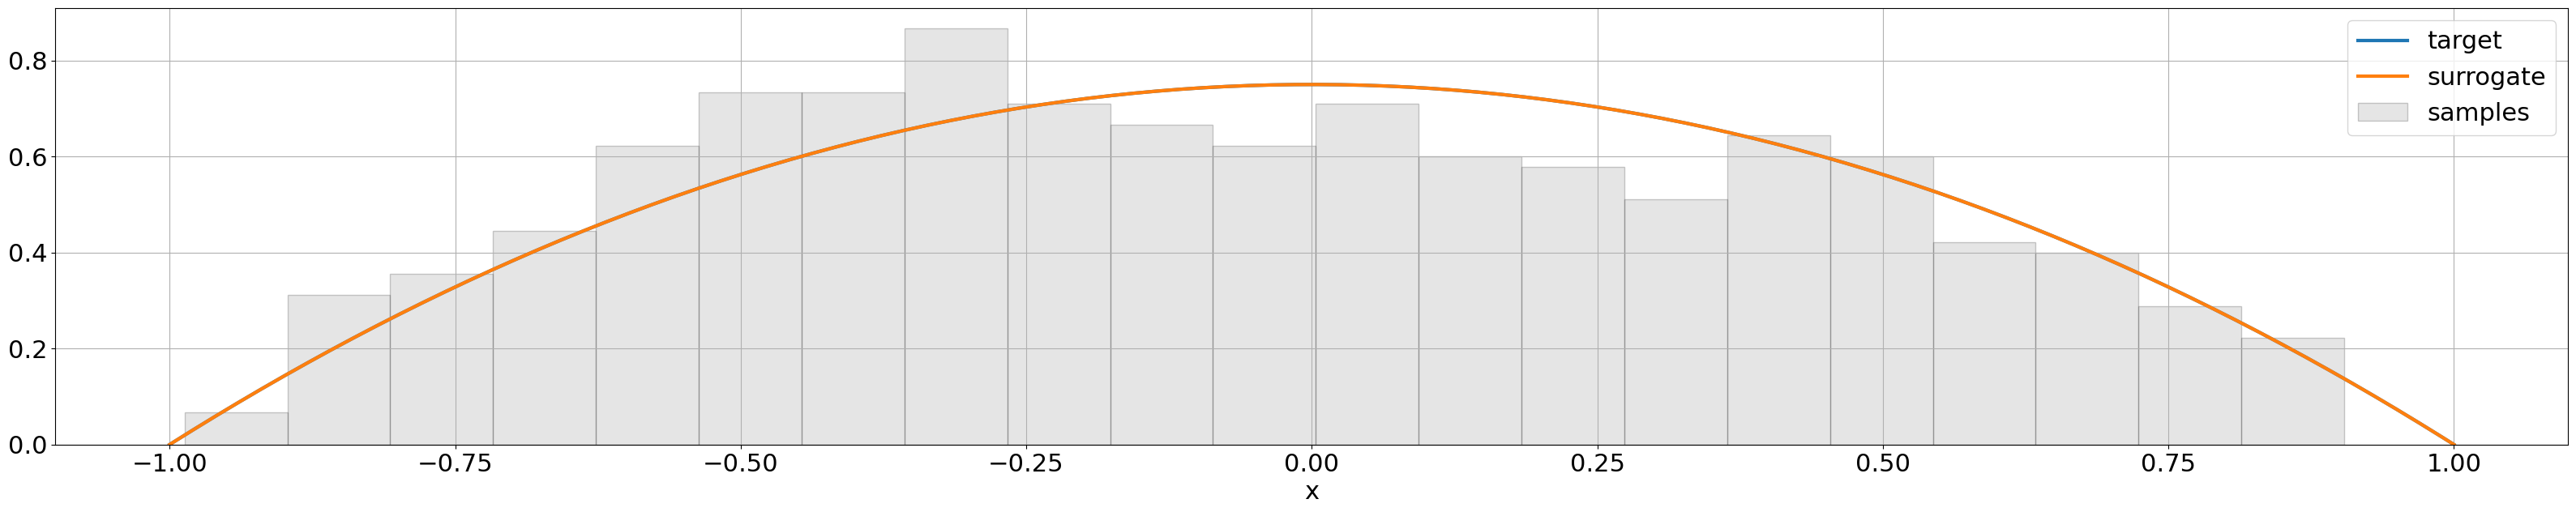

In [182]:
x = np.linspace(-1,1,200)
ax = plotutil.get_ax(plt.figure(), 1, 1)
ax.plot(x, [t_p_1d.eval([xi]) for xi in x], lw=3, label='target')
ax.plot(x, s_p_1d.evalSqrt(x), lw=3, label='surrogate')
ax.hist(p_tar_p_1d[0], bins=21, color='grey', ec='k', alpha=.2, label='samples', density=True)
ax.legend()
plt.show()

# 2D

In [2]:
class Polynomial(TargetDensity) :
    def __init__(self, coeffsx, coeffsy) :
        TargetDensity.__init__(self, 2, 'Polynomial')
        self.coeffsx = coeffsx
        self.coeffsy = coeffsy

    def eval(self, x) :
        return (polyval(x[0], self.coeffsx) * polyval(x[1], self.coeffsy))**2
    
    def coeffs2leg(self, multis) :
        legx = np.pad(leg.poly2leg(self.coeffsx), (0, 10))
        legy = np.pad(leg.poly2leg(self.coeffsy), (0, 10))
        coeffs = np.zeros(len(multis))
        for i in range(len(multis)) :
            coeffs[i] = legx[multis[i][0]] * legy[multis[i][1]] / np.sqrt((2*multis[i][0] + 1)/2) / np.sqrt((2*multis[i][1] + 1)/2)
        return coeffs

In [11]:
t_p = Polynomial([1,1,0], [1,0,0])
m_p = TensorProductSet(dim=2, order=1)
s_p = Legendre(multis=m_p, target=t_p, method='wls')

s_p.coeffs = t_p.coeffs2leg(m_p.asLists())
r_p = TransportMap(s_p)

 ///////////  4 (40, 4) 6.4315949528124134
condition number  1.7522788260673199


In [12]:
p_uni_p, p_tar_p = r_p.samples(200)

In [13]:
lines_p, lines_t_p = r_p.grid(xs=[-1, -.8, -.4, 0, .4, .8, 1], ns=[10, 10, 10, 10, 10, 10])

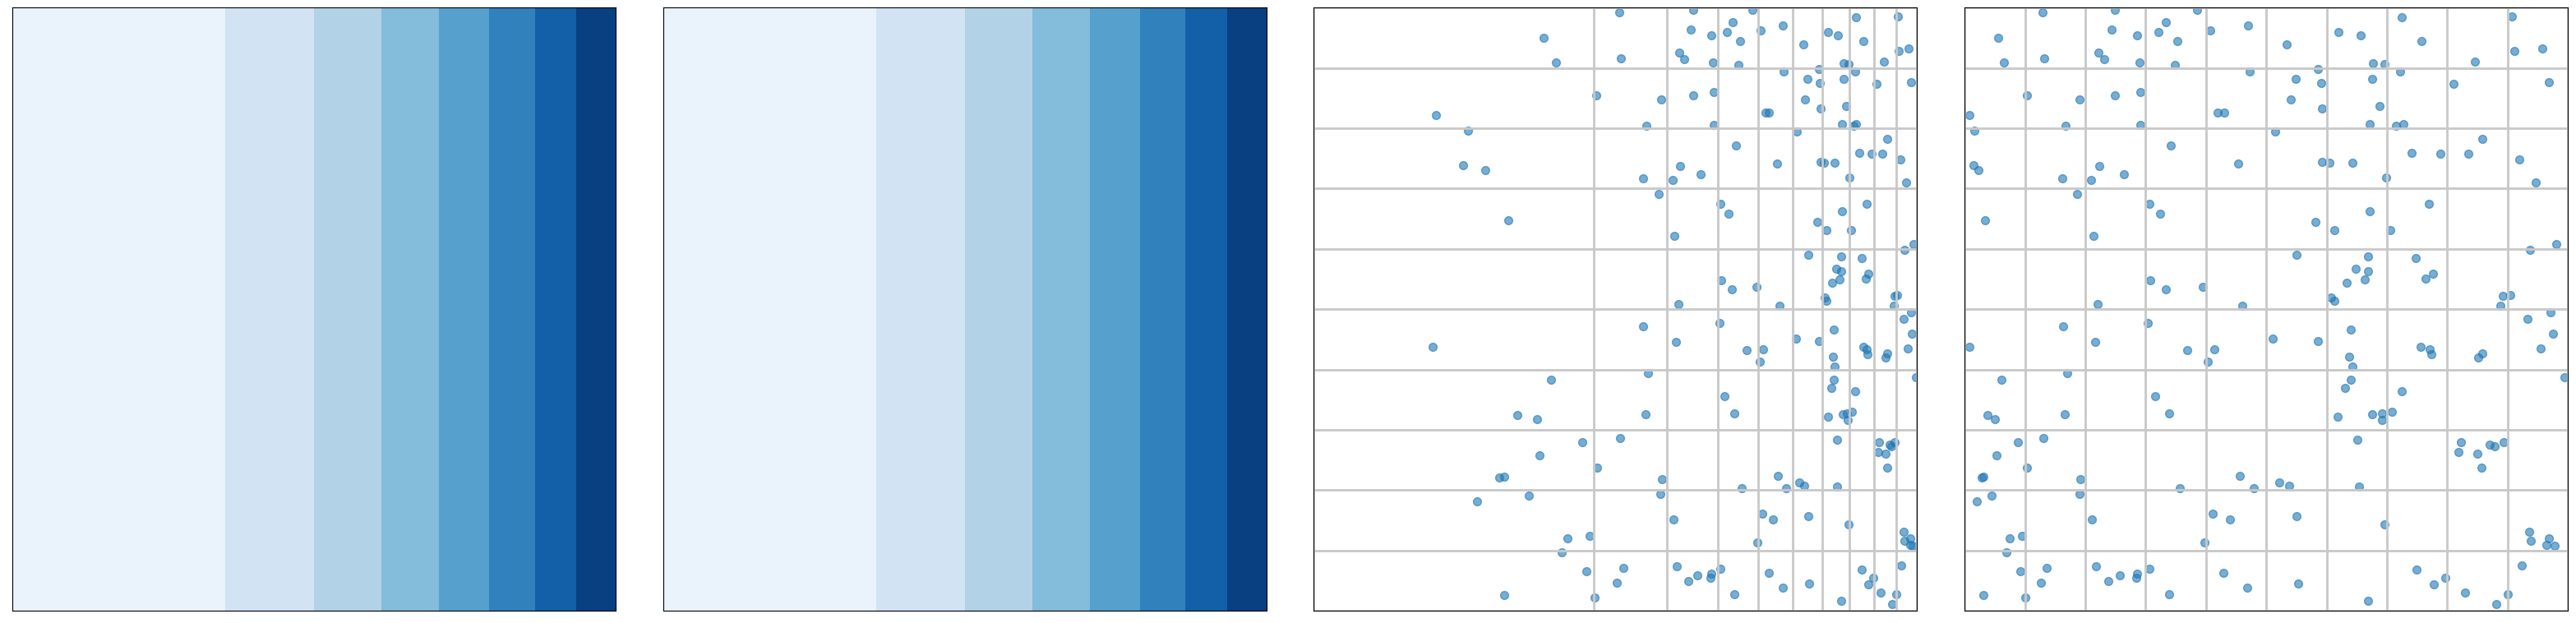

In [14]:
plot_results(t_p, s_p, p_uni_p, p_tar_p, lines_p, lines_t_p)

In [ ]:
n = 50
x = np.linspace(-1,1,n)
X, Y = np.meshgrid(x, x)
sx = np.zeros((n,n,2))
tx = np.zeros((n,n,2))
for i in range(n) :
    for j in range(n) :
        sx[i,j] = r_p.eval([X[i,j],Y[i,j]])
        tx[i,j] = r_p.inveval([X[i,j],Y[i,j]])

In [ ]:
m = 4
X, Y = np.meshgrid(x, x)
fig = plt.figure(figsize=(m*8,8))
ax = get_ax_clean(fig, nx=m, n=1, title=r'$S_1(x)$'); ax.contourf(X, Y, sx[:,:,0], cmap='Blues')
ax = get_ax_clean(fig, nx=m, n=2, title=r'$S_2(x,y)$'); ax.contourf(X, Y, sx[:,:,1], cmap='Blues')
ax = get_ax_clean(fig, nx=m, n=3, title=r'$T_1(x)$'); ax.contourf(X, Y, tx[:,:,0], cmap='Blues')
ax = get_ax_clean(fig, nx=m, n=4, title=r'$T_2(x,y)$'); ax.contourf(X, Y, tx[:,:,1], cmap='Blues')
plt.show()